In [1]:
# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import pandas_ta as ta
import plotly.graph_objects as go
from scipy import stats
from backtesting import Backtest, Strategy
import seaborn as sns
from backtesting.lib import TrailingStrategy

In [ ]:
df = pd.read_csv('data/usdjpydata.csv')

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_values(by='Date', ascending=True)
df.head()

,Open,High,Low,Close
Date,,,,
2025-02-10,151.38,152.53,151.23,151.99
2025-02-07,151.46,152.40,150.95,151.41
2025-02-06,152.62,152.90,151.25,151.46
2025-02-05,154.34,154.46,152.12,152.60
2025-02-04,154.76,155.53,154.17,154.34


In [23]:
# SMA Low and SMA High
sma_low = ta.sma(df["Close"], 50)
sma_high = ta.sma(df["Close"], 100)

df["SMA_Low"] = sma_low
df["SMA_High"] = sma_high

df.tail()

,Open,High,Low,Close,SMA_Low,SMA_High,Signal
Date,,,,,,,
2024-02-16,149.93,150.64,149.83,150.20,151.2896,154.2581,0
2024-02-15,150.60,150.60,149.62,149.94,151.1752,154.1447,0
2024-02-14,150.79,150.88,150.35,150.60,151.0802,154.0338,0
2024-02-13,149.36,150.89,149.27,150.78,150.9990,153.9271,0
2024-02-12,149.31,149.49,148.93,149.35,150.8892,153.8061,0


In [24]:
fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlesticks'
))
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA_Low'],
    line=dict(color='blue'),
    name='SMA_Low'
))
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA_High'],
    line=dict(color='orange'),
    name='SMA_High'
))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)
fig.show()

In [25]:
def sma_signal():
    signal = [0] * len(df)
    for row in range(0, len(df)):
        if (df.iloc[row-1].SMA_Low > df.iloc[row-1].SMA_High and df.iloc[row-2].SMA_Low < df.iloc[row-2].SMA_High):
            signal[row] = 1 #long
        if (df.iloc[row-1].SMA_Low < df.iloc[row-1].SMA_High and df.iloc[row-2].SMA_Low > df.iloc[row-2].SMA_High):
            signal[row] = 2 #short

    df['Signal'] = signal
    return signal

sma_signal()
df[df['Signal']!=0]

,Open,High,Low,Close,SMA_Low,SMA_High,Signal
Date,,,,,,,
2024-07-04,161.69,161.69,160.95,161.28,150.1244,149.6746,1
2024-04-01,151.35,151.76,151.23,151.65,155.0122,155.1889,2


In [26]:
class MyStrat(Strategy):
    mysize = 0.1
    sma_low_len = 50
    sma_high_len = 100

    def init(self):
        super().init()
        df["SMA_Low"] = ta.sma(df.Close, length=self.sma_low_len) 
        df["SMA_High"] = ta.sma(df.Close, length=self.sma_high_len) 
        self.signal = self.I(sma_signal)

    def next(self):
        super().next()
        if self.signal == 1:
            self.buy()
        elif self.signal == 2: 
            self.sell()

bt = Backtest(df, MyStrat, cash=100000, margin=1, commission=.000)
stat = bt.run()
stat

C:\Users\shive\AppData\Local\Temp\ipykernel_17384\3697674981.py:19: UserWarning:

Data index is not sorted in ascending order. Sorting.



Start                     2024-02-12 00:00:00
End                       2025-02-10 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                   39.463602
Equity Final [$]                    106381.18
Equity Peak [$]                     111281.14
Return [%]                            6.38118
Buy & Hold Return [%]                 1.76766
Return (Ann.) [%]                    6.154505
Volatility (Ann.) [%]                7.082803
Sharpe Ratio                         0.868936
Sortino Ratio                        1.430174
Calmar Ratio                         1.397726
Max. Drawdown [%]                   -4.403226
Avg. Drawdown [%]                   -1.316702
Max. Drawdown Duration       35 days 00:00:00
Avg. Drawdown Duration       11 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       6.388362
Worst Trade [%]                      6.388362
Avg. Trade [%]                    

C:\Users\shive\AppData\Local\Temp\ipykernel_17384\2019033573.py:6: UserWarning:

Data index is not sorted in ascending order. Sorting.



  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\shive\AppData\Roaming\Python\Python310\site-packages\backtesting\_stats.py:122: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\shive\AppData\Roaming\Python\Python310\site-packages\backtesting\_stats.py:122: RuntimeWarning:

divide by zero encountered in double_scalars



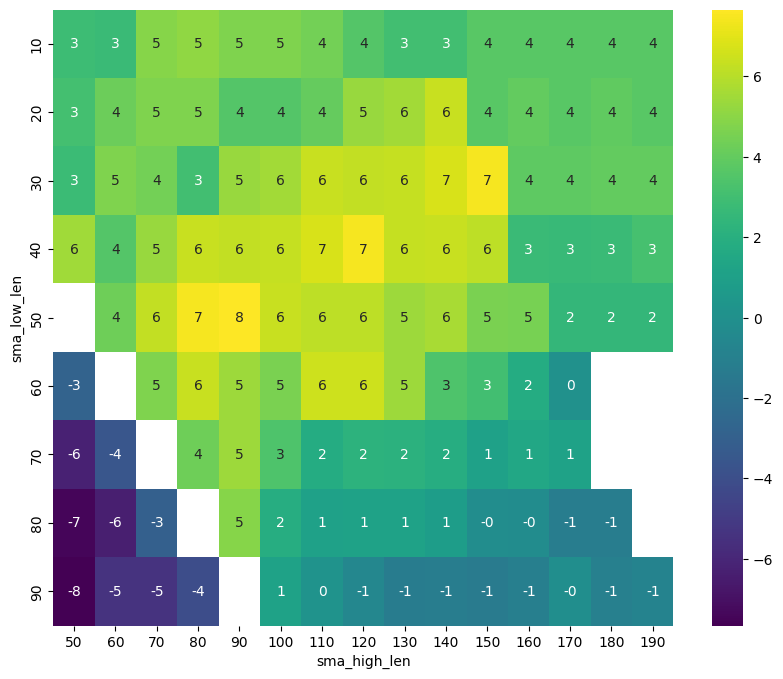

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Backtest optimization
bt = Backtest(df, MyStrat, cash=100000, margin=1, commission=.000)
stats, heatmap = bt.optimize(
                    sma_low_len = range(10,100,10),
                    sma_high_len = range(50,200,10),
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)
stats

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()